In [1]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
from model.locator import Locator
import torchcde
import os

In [2]:
small_te = False

In [3]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-loc-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

In [4]:
# preprocess
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
# Y: t_0, t_E, u_0, rho, q, s, alpha, f_s

# ind_larges = Y[:, 5] > 1
# delta = Y[ind_larges, 4] / (1 + Y[ind_larges, 4]) * (Y[ind_larges, 5] - 1 / Y[ind_larges, 5])
# Y[ind_larges, 0] -= Y[ind_larges, 1] * np.cos(np.pi/180*Y[ind_larges, -2]) * delta

Y_orig = Y.clone()

Y = Y[nanind]
X = X[nanind]
Y_orig = Y_orig[nanind]
Y = Y[:, [0, 1, -1]]

# discard uncertainty bar
X = X[:, :, :2]
Y = Y[:, [0, 1]]

if small_te:
    ind_smallte = torch.where(Y[:, 1] < 40)[0]
    Y = Y[ind_smallte]
    X = X[ind_smallte]
    Y_orig = Y_orig[ind_smallte]

In [5]:
method = 'avg'
if small_te:
    k = 2
    checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_smallte.ckpt', map_location='cpu')
else:
    k = 1/3
    checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_54125.ckpt', map_location='cpu')

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X)

model = Locator(device, k=k, method=method).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

Locator(
  (prefilter): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=reflect)
    (1): PReLU(num_parameters=1)
    (2): Conv1d(16, 16, kernel_size=(15,), stride=(1,), padding=(7,), padding_mode=reflect)
    (3): PReLU(num_parameters=1)
    (4): Conv1d(16, 1, kernel_size=(1,), stride=(1,), padding_mode=reflect)
    (5): PReLU(num_parameters=1)
  )
  (unet): UNET_1D(
    (AvgPool1D1): AvgPool1d(kernel_size=(1,), stride=(5,), padding=(0,))
    (AvgPool1D2): AvgPool1d(kernel_size=(1,), stride=(25,), padding=(0,))
    (AvgPool1D3): AvgPool1d(kernel_size=(1,), stride=(125,), padding=(0,))
    (layer1): Sequential(
      (0): conbr_block(
        (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): PReLU(num_parameters=1)
      )
      (1): re_block(
        (cbr1): conbr_block(
          (conv1): Conv1d(128, 128, k

In [6]:
num = 4096*4
batchsize = 128
pred = torch.zeros((num, 2))
y_ref = torch.zeros((batchsize, 2)).to(device)
z = torch.zeros((num, 4000, 2))
model.eval()
model.plot = False
model.soft_threshold = True
model.threshold = 0.5
model.animate = True
with torch.no_grad():
    for i in tqdm(range(num // batchsize)):
        batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
        y_ref = Y[i*batchsize:i*batchsize+batchsize].float().to(device)
        res = model(batch, y_ref)
        pred[i*batchsize:i*batchsize+batchsize] = res[0].detach().cpu()
        z[i*batchsize:i*batchsize+batchsize] = res[2].detach().cpu()

  0%|          | 0/128 [00:00<?, ?it/s]

tensor([15.2177, 33.2011, 20.7851, 30.0660, 30.7152, 31.0744, 27.8128,  6.1498,
        74.5315, 25.3372], dtype=torch.float64)
[15.654599 32.520317 22.855438 30.122005 31.572355 34.460503 27.230892
  6.31507  80.9482   24.85136 ]
rmse of lgt_E:  0.057155142670710826


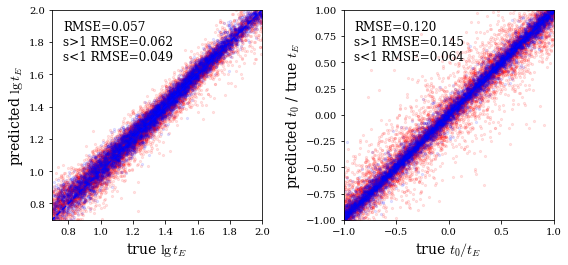

In [7]:
ind_larges = Y_orig[:num, 5] > 1

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
num=4096 * 4

fig = plt.figure(figsize=(8, 4))

ax2 = plt.subplot(1, 2, 1)
plt.axis('square')
plt.xlim(np.log10(5), 2)
plt.ylim(np.log10(5), 2)
plt.xlabel(r'true $\lg t_E$', fontsize=14)
plt.ylabel(r'predicted $\lg t_E$', fontsize=14)
# plt.scatter(np.log10(Y[:num, 1]), np.log10(pred_rand.numpy()[:num, 1]), s=5, alpha=0.1)
plt.scatter(np.log10(Y[:num, 1][ind_larges]), np.log10(pred.numpy()[:num, 1][ind_larges]), s=5, alpha=0.1, label='s>1', color='red', rasterized=True)
plt.scatter(np.log10(Y[:num, 1][~ind_larges]), np.log10(pred.numpy()[:num, 1][~ind_larges]), s=5, alpha=0.1, label='s<1', color='blue', rasterized=True)
plt.plot(np.linspace(0, 2), np.linspace(0, 2), color='b', linestyle='dashed')
at = AnchoredText(
        "RMSE=%.3f\ns>1 RMSE=%.3f\ns<1 RMSE=%.3f" % (
            np.sqrt(torch.mean((np.log10(Y[:num, 1]) -  np.log10(pred.numpy()[:num, 1]))**2).detach().cpu().item()),
            np.sqrt(torch.mean((np.log10(Y[:num, 1])[ind_larges] -  np.log10(pred.numpy()[:num, 1])[ind_larges])**2).detach().cpu().item()),
            np.sqrt(torch.mean((np.log10(Y[:num, 1])[~ind_larges] -  np.log10(pred.numpy()[:num, 1])[~ind_larges])**2).detach().cpu().item()),
            ), prop=dict(size=12), frameon=False, loc='upper left')
ax2.add_artist(at)
print(Y[:10, 1])
print(pred.numpy()[:10, 1])
print('rmse of lgt_E: ', torch.sqrt((torch.mean((np.log10(Y[:num, 1]) -  np.log10(pred.numpy()[:num, 1]))**2, dim=0))).detach().cpu().item())

ax3 = plt.subplot(1, 2, 2)
plt.axis('square')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r'true $t_0/t_E$', fontsize=14)
plt.ylabel(r'predicted $t_0$ / true $t_E$', fontsize=14)
plt.scatter((Y[:num, 0] / Y[:num, 1])[ind_larges], (pred.numpy()[:num, 0] / Y[:num, 1])[ind_larges], s=5, alpha=0.1, label='s>1', color='red', rasterized=True)
plt.scatter((Y[:num, 0] / Y[:num, 1])[~ind_larges], (pred.numpy()[:num, 0] / Y[:num, 1])[~ind_larges], s=5, alpha=0.1, label='s<1', color='blue', rasterized=True)
plt.plot(np.linspace(0, 2), np.linspace(0, 2), color='b', linestyle='dashed')
at = AnchoredText(
        "RMSE=%.3f\ns>1 RMSE=%.3f\ns<1 RMSE=%.3f" % (
            np.sqrt(torch.mean((Y[:num, 0] / Y[:num, 1] -  (pred.numpy()[:num, 0] / Y[:num, 1]))**2).detach().cpu().item()),
            np.sqrt(torch.mean(((Y[:num, 0] / Y[:num, 1])[ind_larges] -  (pred.numpy()[:num, 0] / Y[:num, 1])[ind_larges])**2).detach().cpu().item()),
            np.sqrt(torch.mean(((Y[:num, 0] / Y[:num, 1])[~ind_larges] -  (pred.numpy()[:num, 0] / Y[:num, 1])[~ind_larges])**2).detach().cpu().item()),
            ), prop=dict(size=12), frameon=False, loc='upper left')
ax3.add_artist(at)

plt.tight_layout()
plt.show()

In [8]:
lc_smalls = X[:num][~ind_larges]
y_smalls = Y[:num][~ind_larges]
z_smalls = z[:num][~ind_larges]
y_orig_smalls = Y_orig[:num][~ind_larges]
lc_smalls[:, :, 0] = (lc_smalls[:, :, 0] - y_smalls[:, [0]]) / y_smalls[:, [1]]
z_smalls[:, :, 0] = (z_smalls[:, :, 0] - y_smalls[:, [0]]) / y_smalls[:, [1]]

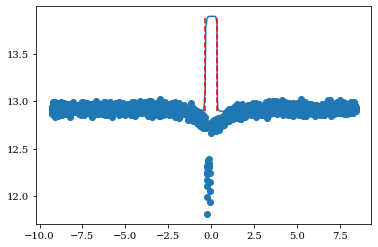

In [9]:
i = 0
plt.scatter(lc_smalls[i, :, 0], lc_smalls[i, :, 1])
plt.plot(z_smalls[i, :, 0], z_smalls[i, :, 1] + lc_smalls[i, :, 1].mean())
plt.vlines([-k, k], lc_smalls[i, :, 1].mean(), lc_smalls[i, :, 1].mean() + 1, linestyles='dashed', color='red')

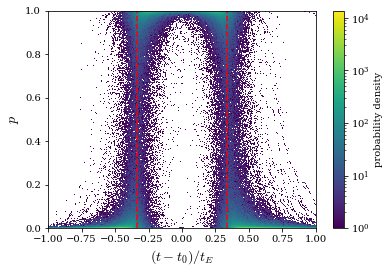

In [22]:
plt.hist2d(z_smalls[:, :, 0].numpy().flatten(), z_smalls[:, :, 1].numpy().flatten(), bins=[10000, 1000], density=False, norm=mpl.colors.LogNorm())
plt.xlim(-1, 1)
plt.xlabel(r'$(t-t_0)/t_E$', fontsize=14)
plt.ylabel(r'$p$', fontsize=14)
plt.ylim(0, 1)
plt.colorbar(label='probability density')
plt.vlines([-k, k], 0, 1, linestyles='dashed', color='red')
plt.show()